# Advanced RAG with LlamaParse + Vectara

This notebook shows you how to use LlamaParse with Vectara.

In [1]:
#!pip install llama-index llama-index-core llama-parse llama-index-indices-managed-vectara

In [3]:
!wget 'https://raw.githubusercontent.com/run-llama/llama_index/main/docs/examples/data/10q/uber_10q_march_2022.pdf' -O './uber_10q_march_2022.pdf'
fname = './uber_10q_march_2022.pdf'

--2024-03-17 17:49:50--  https://raw.githubusercontent.com/run-llama/llama_index/main/docs/examples/data/10q/uber_10q_march_2022.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1260185 (1.2M) [application/octet-stream]
Saving to: ‘./uber_10q_march_2022.pdf’

./uber_10q_march_20 100%[===================>]   1.20M  --.-KB/s    in 0.05s   

2024-03-17 17:49:50 (24.0 MB/s) - ‘./uber_10q_march_2022.pdf’ saved [1260185/1260185]



In [4]:
# llama-parse is async-first, running the async code in a notebook requires the use of nest_asyncio
import nest_asyncio
nest_asyncio.apply()

import os
# API access to llama-cloud
os.environ["LLAMA_CLOUD_API_KEY"] = "llx-..."

# Using OpenAI API for embeddings/llms
os.environ["OPENAI_API_KEY"] = "sk-..."

## Using `LlamaParse` PDF reader to parse the file

We feed the Uber March 2022 10QA into LlamaParse to get back the Markdown representation.

In [5]:
from llama_parse import LlamaParse

documents = LlamaParse(result_type="markdown", verbose=True, language="en").load_data(fname)

Started parsing the file under job_id 18f761da-29ba-43df-8594-ecdff2d9d382


## Setup Vectara as a query engine

We compare to different retreival-query strategues:
1. Upload the PDF directly to Vectara
2. Upload the parsed markdown version of the PDF, generated by `LlamaParse` to vectara

In [6]:
from llama_index.indices.managed.vectara import VectaraIndex

vectara_customer_id = "<YOUR-VECTARA-CUSTOMER-ID>"
vectara_corpus_id1 = "<VECTARA-CORPUS-ID-1>"
vectara_corpus_id2 = "<VECTARA-CORPUS-ID-2>"
vectara_api_key = "zwt_..."

In [13]:
# with vectara1, we upload the markdown file that is the output of the LlamaParse processing to Vectara

temp_fname = 'temp.md'
with open(temp_fname, 'w') as f:
    f.write(documents[0].text)
vectara1 = VectaraIndex(vectara_customer_id=vectara_customer_id, 
                        vectara_corpus_id=vectara_corpus_id1, 
                        vectara_api_key=vectara_api_key)
vectara1.insert_file(temp_fname)
qe1 = vectara1.as_query_engine(similarity_top_k=10)

LLM is explicitly disabled. Using MockLLM.
Embeddings have been explicitly disabled. Using MockEmbedding.


In [14]:
# with vectara2, we upload the PDF directly to Vectara

vectara2 = VectaraIndex(vectara_customer_id=vectara_customer_id, 
                        vectara_corpus_id=vectara_corpus_id2, 
                        vectara_api_key=vectara_api_key)
vectara2.insert_file(fname)
qe2 = vectara2.as_query_engine(similarity_top_k=10)

LLM is explicitly disabled. Using MockLLM.
Embeddings have been explicitly disabled. Using MockEmbedding.


## Let's compare

### We compare the two upload methods and run a few example queries

In [15]:
query = "how is the Cash paid for Income taxes, net of refunds from Supplemental disclosures of cash flow information?"

response_1 = qe1.query(query)
print("\n*** Vectara + LlamaParse ***")
print(response_1)

response_2 = qe2.query(query)
print("\n*** Vectara Native ***")
print(response_2)



*** Vectara + LlamaParse ***
The Cash paid for Income taxes, net of refunds is disclosed in the Supplemental disclosures of cash flow information. For the period ending March 31, 2022, the amount paid for income taxes, net of refunds, was $41 million, compared to $22 million for the same period in 2021 [6]. This information is crucial for understanding the cash flow activities related to income taxes and refunds within the financial statements of the company. Additionally, the reconciliation of cash flow activities shows the net cash provided by operating activities, investing activities, and financing activities for the respective periods, providing a comprehensive view of the company's liquidity and capital resources [7].

*** Vectara Native ***
The Cash paid for Income taxes, net of refunds is disclosed in the Supplemental disclosures of cash flow information. The cash paid for Income taxes includes amounts net of refunds received. Additionally, the provision for Income Taxes is de

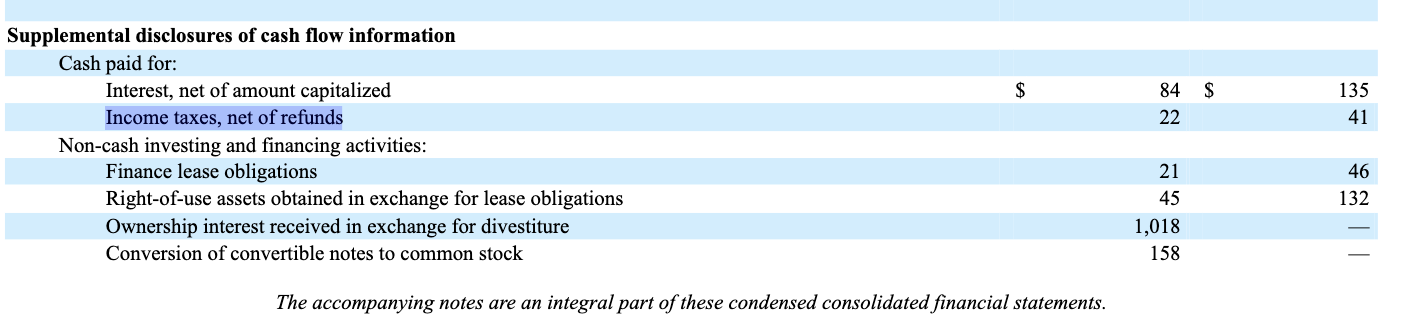

In [16]:
query = "what is the change of free cash flow and what is the rate from the financial and operational highlights?"

response_1 = qe1.query(query)
print("\n*** Vectara + LlamaParse ***")
print(response_1)

response_2 = qe2.query(query)
print("\n*** Vectara Native ***")
print(response_2)


*** Vectara + LlamaParse ***
The change in free cash flow from the financial and operational highlights shows a significant improvement. In the comparison between the periods, there was a notable decrease in free cash flow from $(682) million to $(47) million[5]. Additionally, the financial data indicates a substantial increase in revenue from $2,903 million to $6,854 million, representing a growth rate of 136% to 141%[3]. The adjusted EBITDA also saw positive growth, with Mobility Adjusted EBITDA increasing by 107% and Delivery Adjusted EBITDA showing improvement as well[3]. These financial and operational highlights demonstrate the company's performance and changes in key metrics over the specified periods.

*** Vectara Native ***
The change in free cash flow for the periods indicated was a decrease from $(611) million in 2021 to $15 million in 2022[6]. The financial and operational highlights show a 17% increase in Monthly Active Platform Consumers from 98 in 2021 to 115 in 2022[7]

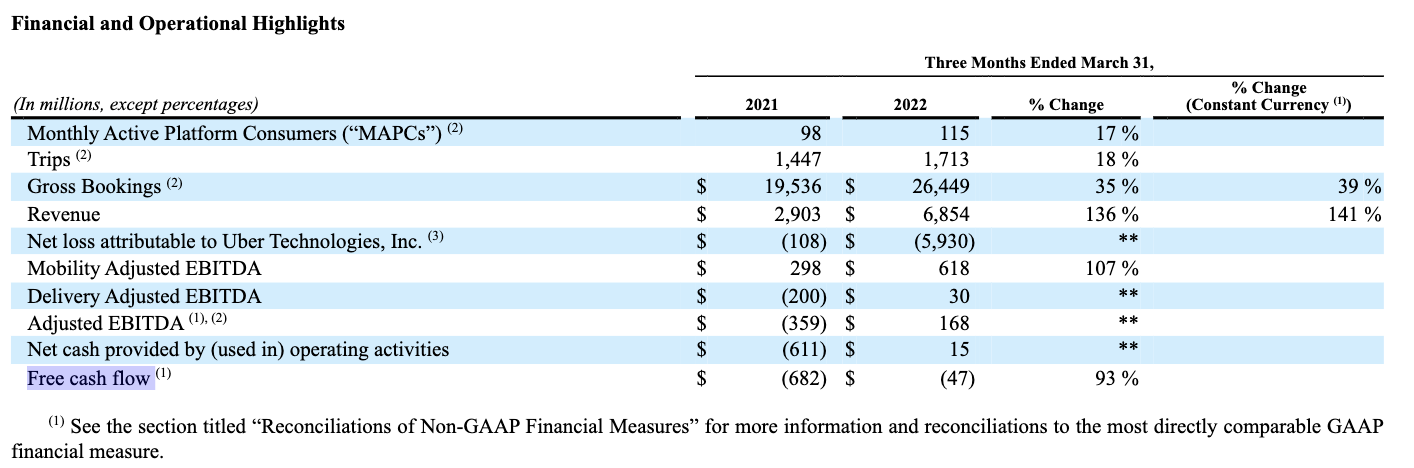

In [17]:
query = "what is the net loss value attributable to Uber compared to last year?"

response_1 = qe1.query(query)
print("\n*** Vectara + LlamaParse ***")
print(response_1)

response_2 = qe2.query(query)
print("\n*** Vectara Native ***")
print(response_2)


*** Vectara + LlamaParse ***
The net loss attributable to Uber Technologies, Inc. for the current year was $5.9 billion, which includes various unrealized losses on investments and stock-based compensation expenses[2]. This represents a significant increase compared to the previous year, with Adjusted EBITDA improving by $527 million[3]. The revenue growth outpaced Gross Bookings growth, driven by various factors including acquisitions and changes in accounting models[1]. The comprehensive financial data also shows a detailed breakdown of assets, liabilities, and equity for the company over the specified periods[5]. The net loss value attributable to Uber this year reflects a substantial change compared to the previous year, influenced by various financial factors and business activities.

*** Vectara Native ***
The net loss attributable to Uber Technologies, Inc. compared to last year was $5.930 billion for the current period, a significant increase from the previous year. This net l

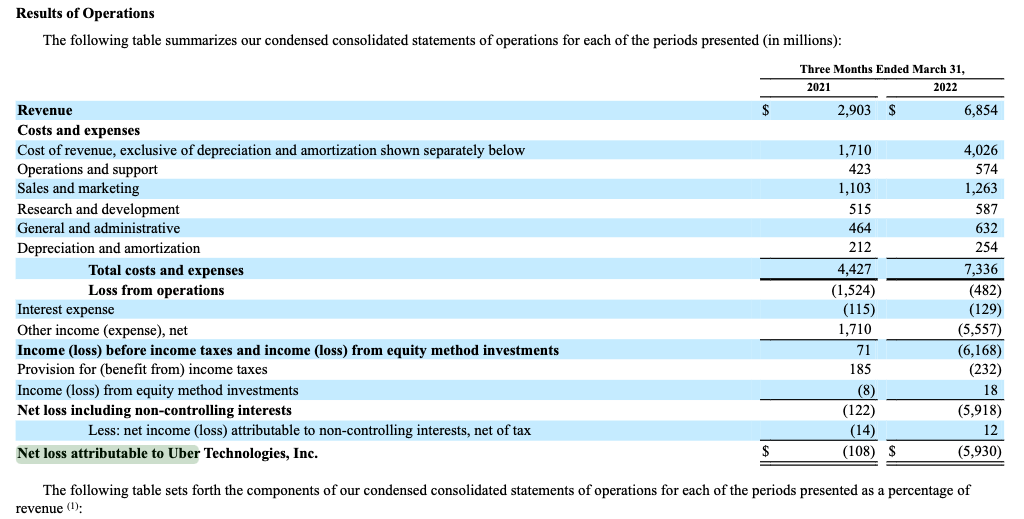

In [18]:
query = "What were cash flows like from investing activities?"

response_1 = qe1.query(query)
print("\n*** Vectara + LlamaParse ***")
print(response_1)

response_2 = qe2.query(query)
print("\n*** Vectara Native ***")
print(response_2)


*** Vectara + LlamaParse ***
Net cash used in investing activities varied over the periods analyzed. In the three months ended March 31, 2022, it amounted to $(135) million, mainly due to purchases of property and equipment and acquisition of business [4]. In contrast, for the same period in 2021, it was $(250) million, primarily driven by purchases of non-marketable equity securities, marketable securities, and a note receivable, partially offset by proceeds from maturities and sales of marketable securities and the sale of non-marketable equity securities [5]. These fluctuations in investing activities impacted the overall cash flows during the respective periods.

*** Vectara Native ***
Cash flows from investing activities for the period included purchases of property and equipment, marketable securities, and acquisitions of businesses, resulting in a net cash used in investing activities of $250 million to $135 million[7]. Additionally, there were other investing activities contri

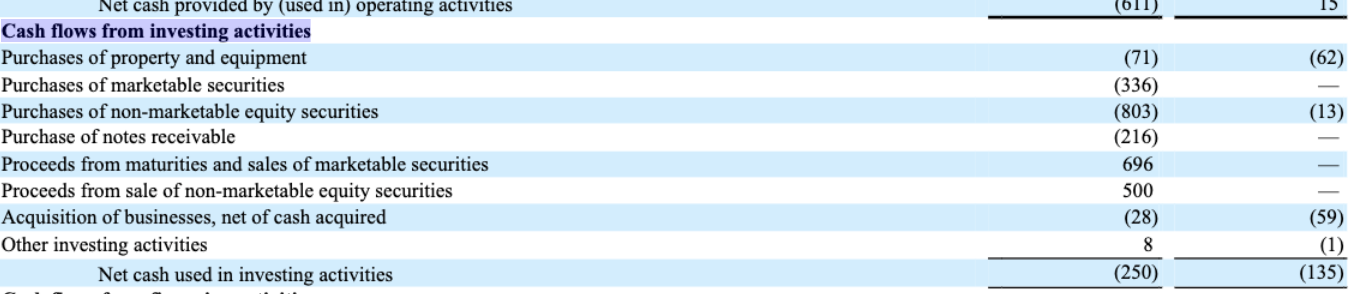